<a href="https://colab.research.google.com/github/DarshanGowda0/MusicalInstrumentsClassification/blob/main/CNN_mfcc_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to TPU


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.4.1
Running on TPU  ['10.114.90.50:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.114.90.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.114.90.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


# Load preprocessed data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import librosa, librosa.display
import os
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

!pip install --upgrade tables

df = pd.read_hdf('/content/drive/MyDrive/mfcc-16-128-and-other-features.h5', key='s', mode='r')

     |████████████████████████████████| 4.3MB 6.2MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [ ]:
from sklearn.utils import shuffle

INSTRUMENTS = ['flu', 'pia', 'tru', 'gac', 'voi', 'org']
df = df.loc[df['label'].isin(INSTRUMENTS)]

df = shuffle(df)
print(df.columns)

Index(['mfcc', 'chroma_stft', 'rms', 'spec_centroid', 'spec_bandwidth',
       'rolloff', 'zero_crossing_rate', 'label'],
      dtype='object')


# Normalize the data

In [ ]:
X, y = df['mfcc'], df['label']
y_cat = le.fit_transform(y)
X = np.stack([x for x in X])
X = np.expand_dims(X, axis=-1)

In [ ]:
from collections import Counter
print(X.shape, Counter(y))

(3846, 128, 16, 1) Counter({'voi': 778, 'pia': 721, 'org': 682, 'gac': 637, 'tru': 577, 'flu': 451})


In [ ]:
mean = np.mean(X, axis=(1,2), keepdims=True)
std = np.std(X, axis=(1,2), keepdims=True)
X_std = (X - mean) / std

## Split train and test

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

X_train, X_test, y_train, y_test = train_test_split(X_std, y_cat, test_size=0.15)
X_train.shape, y_train.shape, X_test.shape

((3269, 128, 16, 1), (3269,), (577, 128, 16, 1))

# CNN Model

In [ ]:
def create_model():

  model = keras.Sequential([
                            keras.layers.Conv2D(filters=32, kernel_size=(3,3),
                                                padding='same', activation='relu',
                                                input_shape=(X.shape[1], X.shape[2], 1),
                                                # activity_regularizer=keras.regularizers.l2(0.005)
                                                ),

                            keras.layers.MaxPool2D(pool_size=(2,2)),

                            keras.layers.Dropout(0.25),

                            keras.layers.Conv2D(filters=64, kernel_size=(3,3),
                                                padding='same', activation='relu',
                                                # activity_regularizer=keras.regularizers.l2(0.005),
                                                ),

                            keras.layers.MaxPool2D(pool_size=(2,2)),

                            keras.layers.Dropout(0.25),

                            # keras.layers.Conv2D(filters=128, kernel_size=(3,3),
                            #                     padding='same', activation='relu',
                            #                     # activity_regularizer=keras.regularizers.l2(0.005)
                            #                     ),

                            # keras.layers.MaxPool2D(pool_size=(2,2)),

                            # keras.layers.Dropout(0.25),

                            # keras.layers.GlobalMaxPool2D(),

                            # keras.layers.Dropout(0.25),

                            keras.layers.Flatten(),

                            keras.layers.Dense(256, activation='relu', 
                                              #  activity_regularizer=keras.regularizers.l2(0.001)
                                               ),

                            keras.layers.Dropout(0.5),

                            keras.layers.Dense(11, activation='softmax')
  ])

  # optimizer = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  
  return model

In [ ]:
y_test

array([2, 4, 0, 3, 4, 5, 1, 5, 2, 4, 5, 0, 4, 0, 0, 5, 2, 5, 2, 4, 5, 3,
       4, 5, 1, 2, 2, 3, 3, 2, 2, 5, 2, 5, 3, 1, 2, 2, 4, 1, 3, 2, 0, 3,
       5, 4, 2, 4, 2, 2, 2, 3, 5, 2, 1, 2, 2, 1, 1, 2, 2, 0, 2, 3, 1, 5,
       2, 5, 4, 2, 0, 3, 0, 2, 0, 3, 0, 2, 5, 5, 5, 5, 3, 4, 3, 0, 4, 1,
       0, 4, 3, 2, 4, 4, 3, 4, 5, 1, 2, 4, 3, 5, 5, 3, 1, 5, 1, 1, 1, 1,
       0, 2, 1, 1, 4, 5, 2, 2, 5, 5, 5, 1, 0, 5, 4, 4, 5, 4, 0, 2, 4, 1,
       5, 4, 2, 2, 3, 5, 1, 1, 1, 5, 3, 4, 5, 0, 3, 2, 0, 4, 5, 3, 5, 3,
       3, 5, 5, 2, 5, 4, 1, 5, 1, 3, 5, 5, 3, 2, 2, 2, 1, 1, 5, 2, 5, 2,
       4, 5, 0, 0, 4, 4, 1, 0, 4, 5, 5, 5, 3, 3, 1, 3, 4, 0, 4, 5, 3, 3,
       2, 2, 2, 4, 0, 3, 5, 2, 3, 1, 5, 5, 5, 5, 1, 4, 3, 2, 5, 4, 4, 0,
       5, 5, 2, 2, 1, 2, 1, 1, 3, 5, 0, 1, 3, 5, 1, 5, 0, 1, 3, 1, 0, 2,
       5, 0, 0, 3, 2, 1, 3, 5, 5, 1, 1, 1, 3, 4, 5, 5, 3, 1, 2, 4, 5, 1,
       4, 3, 1, 4, 3, 2, 5, 5, 1, 4, 3, 4, 3, 5, 3, 5, 1, 2, 5, 1, 2, 3,
       0, 3, 1, 4, 1, 1, 3, 2, 1, 4, 3, 3, 0, 1, 4,

In [ ]:
with tpu_strategy.scope():
  model = create_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 16, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 8, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 8, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 8, 64)         18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 4, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 4, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=500)

Epoch 1/500
103/103 [==============================] - 9s 58ms/step - loss: 1.9840 - accuracy: 0.2058 - val_loss: 1.7596 - val_accuracy: 0.3102
Epoch 2/500
103/103 [==============================] - 2s 21ms/step - loss: 1.6539 - accuracy: 0.3229 - val_loss: 1.6735 - val_accuracy: 0.3761
Epoch 3/500
103/103 [==============================] - 2s 20ms/step - loss: 1.5339 - accuracy: 0.3977 - val_loss: 1.5913 - val_accuracy: 0.4107
Epoch 4/500
103/103 [==============================] - 2s 22ms/step - loss: 1.4386 - accuracy: 0.4386 - val_loss: 1.5361 - val_accuracy: 0.4402
Epoch 5/500
103/103 [==============================] - 2s 21ms/step - loss: 1.3831 - accuracy: 0.4629 - val_loss: 1.4394 - val_accuracy: 0.4783
Epoch 6/500
103/103 [==============================] - 2s 21ms/step - loss: 1.3660 - accuracy: 0.4861 - val_loss: 1.4192 - val_accuracy: 0.5026
Epoch 7/500
103/103 [==============================] - 2s 22ms/step - loss: 1.3059 - accuracy: 0.5096 - val_loss: 1.3924 - val_accuracy:

loss: 0.49377259612083435
val_loss: 0.6498277187347412


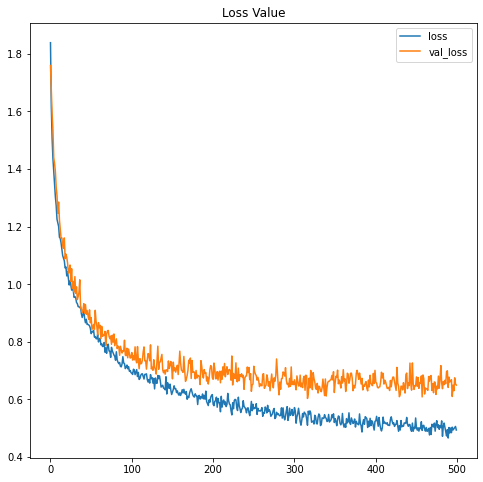

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.title('Loss Value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
print('loss:', history.history['loss'][-1])
print('val_loss:', history.history['val_loss'][-1])

acc: 0.8213521242141724
val_acc: 0.7833622097969055


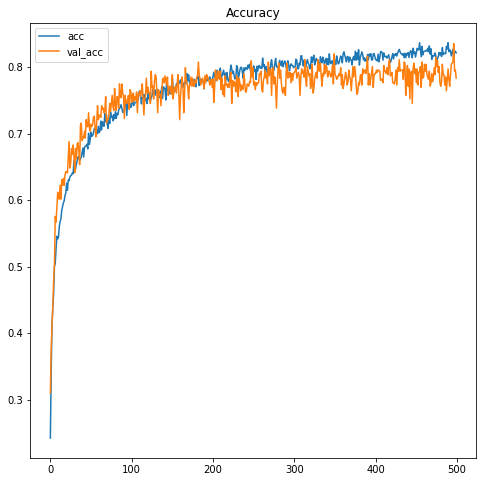

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])
print('acc:', history.history['accuracy'][-1])
print('val_acc:', history.history['val_accuracy'][-1])

In [ ]:
model.save_weights('/content/drive/MyDrive/CNN-model/first')

# Experimenting on evals

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')
  """
  #print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import recall_score, precision_score, accuracy_score
import seaborn as sns #visualization library, must be imported before all other plotting libraries
import matplotlib.pyplot as plt

In [ ]:
from collections import Counter
Counter(y)

Counter({'flu': 451,
         'gac': 637,
         'org': 682,
         'pia': 721,
         'tru': 577,
         'voi': 778})

In [ ]:
def plot_confusion_matrix(cnf_matrix):
  df_cm = pd.DataFrame(cnf_matrix, index=INSTRUMENTS, columns=INSTRUMENTS)
  plt.figure(figsize = (10,7))
  sns.set(font_scale=1.0) #for label size
  sns.heatmap(df_cm, annot=True, annot_kws={'size': 18}, fmt='g') # font size
  plt.show()

def display_score(y_test, y_pred):
  print('Recall: ', recall_score(y_test, y_pred, average=None))
  print('Precision: ', precision_score(y_test, y_pred, average=None))
  print('F1-Score: ', f1_score(y_test, y_pred, average=None))
  print('Accuracy: %.2f ' % accuracy_score(y_test, y_pred, normalize=True))
  print('Number of samples: ', y_test.shape[0])



In [ ]:
y_pred = model.predict(X_test)
y_pred_cat = np.argmax(y_pred, axis=1)

In [ ]:
display_score(y_test, y_pred_cat)

Recall:  [0.69230769 0.71681416 0.86725664 0.87128713 0.72093023 0.78787879]
Precision:  [0.69230769 0.87096774 0.66216216 0.72727273 0.95384615 0.91764706]
F1-Score:  [0.69230769 0.78640777 0.75095785 0.79279279 0.82119205 0.84782609]
Accuracy: 0.78 
Number of samples:  577


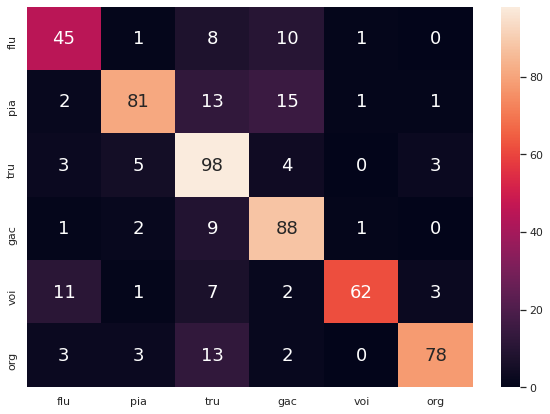

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred_cat)
plot_confusion_matrix(cnf_matrix)  